### **Tensorflow-GPU cehck**

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.get_logger().setLevel('INFO')
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
tf.sysconfig.get_build_info()

2022-01-20 15:07:20.540752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-20 15:07:22.515374: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


OrderedDict([('cpu_compiler',
              '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614534878484/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'),
             ('cuda_compute_capabilities',
              ['compute_35',
               'compute_52',
               'compute_60',
               'compute_61',
               'compute_70',
               'compute_75']),
             ('cuda_version', '10.1'),
             ('cudnn_version', '7'),
             ('is_cuda_build', True),
             ('is_rocm_build', False)])

2022-01-20 15:07:22.516670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-20 15:07:22.596533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.665GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-01-20 15:07:22.596579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-20 15:07:22.599162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-20 15:07:22.599208: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-01-20 15:07:22.601103: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.

## **Module**

In [2]:
import os
import re
import gc
import pickle
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
from itertools import chain
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
from matplotlib import rcParams
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

# sklearn
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

# keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Lambda, Add, Multiply, Layer, BatchNormalization, Activation
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,Callback
from tensorflow.keras import metrics, optimizers
from tensorflow.keras import backend as K

# rpy2
os.environ['R_HOME'] = '/home/km/anaconda3/envs/multiomics/lib/R' # env R invoke
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

#!python -m rpy2.situation

### **File Path**

In [3]:
CANCER_TYPE = "LIHC"
FILE_NAME = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
RAW_file_path = "/home/km/gitworking/Multi-omics-intergration/RAW_DATA/"
PKL_file_path = "/home/km/gitworking/Multi-omics-intergration/pkl/"
MODEL_PATH = "/home/km/gitworking/Multi-omics-intergration/models/"
TENSORBOARD_PATH = '/home/km/gitworking/Multi-omics-intergration/log'
GROUP_PHTH = '/home/km/gitworking/Multi-omics-intergration/group/'
PNG_PATH = '/home/km/gitworking/Multi-omics-intergration/png/'
print(FILE_NAME)

20220120-150723


## **UDF**

In [80]:
def cancer_select(cols, cancer_type):
    # phenotype
    phe1 = pd.read_csv("https://gdc-hub.s3.us-east-1.amazonaws.com/download/GDC-PANCAN.basic_phenotype.tsv.gz", sep="\t")
    phe1 = phe1.loc[phe1.program == "TCGA", :].loc[:, ['sample', 'sample_type', 'project_id']].drop_duplicates(['sample'])
    phe1['sample'] =  phe1.apply(lambda x : x['sample'][:-1], axis=1)
    phe2 = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/TCGA_phenotype_denseDataOnlyDownload.tsv.gz", sep="\t")
    ph_join = pd.merge(left = phe2 , right = phe1, how = "left", on = "sample").dropna(subset=['project_id'])
    
    if cancer_type == "PAN" or cancer_type == "PANCAN":
        filterd = ph_join.loc[ph_join['sample_type_y'] == "Primary Tumor", :]
        sample_barcode = filterd["sample"].tolist()
    else:
        filterd = ph_join.loc[(ph_join['sample_type_y'] == "Primary Tumor") & (ph_join['project_id'] == "TCGA-" + cancer_type) , :]
        sample_barcode = filterd["sample"].tolist()
        
    intersect_ = list(set(cols).intersection(sample_barcode))
    
    return intersect_

def non_zero_column(DF):
    sample_cnt = int(len(DF.columns) * 0.2)
    zero_row = dict(DF.isin([0]).sum(axis=1))
    non_remove_feature = list()

    for key, value in zero_row.items():
        if value < sample_cnt:
            non_remove_feature.append(key)
    
    return non_remove_feature

def load_tcga_dataset(pkl_path, raw_path, cancer_type, norm, minmax=None):
    
    if os.path.isfile(pkl_path + "/" + cancer_type + "_omics.pkl"):
        omics = pd.read_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")

        # sep
        rna = pd.read_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")
        mirna = pd.read_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")
        mt = pd.read_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
        # intersect
        venn3_unweighted([set(rna.index), set(mirna.index), set(mt.index)], ('RNA', 'miRNA', 'Methylation'))
        plt.show()
        
    else :
        # RNA gene expression
        col = pd.read_csv(raw_path + "tcga_RSEM_Hugo_norm_count.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)
        df_chunk = pd.read_csv(raw_path + "tcga_RSEM_Hugo_norm_count.gz",
                     sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        rna = pd.concat([chunk for chunk in df_chunk])
        rna = rna[rna.index.isin(non_zero_column(rna))].T
        
        rna.to_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")

        # miRNA expression
        col = pd.read_csv(raw_path + "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)

        df_chunk = pd.read_csv(raw_path + "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz",
                         sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        mirna = pd.concat([chunk for chunk in df_chunk])
        mirna = mirna[mirna.index.isin(non_zero_column(mirna))].T
        
        mirna.to_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")

        # methylation
        col = pd.read_csv(raw_path + "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)

        df_chunk = pd.read_csv(raw_path + "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz",
                         sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        mt = pd.concat([chunk for chunk in df_chunk])

        mt_map = pd.read_csv(raw_path + "probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy", sep="\t")

        mt_join = pd.merge(mt, mt_map, how = "left", left_on = "sample", right_on = "#id")\
                 .drop(['chrom', 'chromStart', 'chromEnd', 'strand', '#id'], axis=1)
        mt_join = mt_join[mt_join.gene != "."]
        mt_join.dropna(subset = ["gene"], inplace=True)

        # gene mean 
        mt_join_gene_filter = mt_join.groupby(['gene']).mean()
        mt_join_gene_filter = mt_join_gene_filter[mt_join_gene_filter.index.isin(non_zero_column(mt_join_gene_filter))].T
        
        mt_join_gene_filter.to_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
        # intersect
        venn3_unweighted([set(rna.index), set(mirna.index), set(mt_join_gene_filter.index)], ('RNA', 'miRNA', 'Methylation'))
        plt.show()
        
        # set same column for merge
        rna['sample'] = rna.index
        mirna['sample'] = mirna.index
        mt_join_gene_filter['sample'] = mt_join_gene_filter.index

        # data join
        merge_list = [rna, mirna, mt_join_gene_filter]
        omics = reduce(lambda left, right : pd.merge(left, right, on = "sample"), merge_list)
        omics.set_index('sample', inplace=True)

        # pickle save
        omics.to_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")
    
    # set index
    omics_index = omics.index.to_list()
    
    # normalization
    if norm:
        if minmax:
            scalerX = MinMaxScaler()
            omics_scale = scalerX.fit_transform(omics)
        else :
            scalerX = StandardScaler()      
            omics_scale = scalerX.fit_transform(omics)
    
    # missing impute
    imputer = KNNImputer(n_neighbors=10)
    omics_impute = imputer.fit_transform(omics_scale)

    omics = pd.DataFrame(omics_impute, columns=omics.columns)
    omics.index = omics_index

    return omics

def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name) 
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
    return os.path.join(root_logdir, sub_dir_name)

# autoencoder
def run_ae(X_train, X_test):
    tf.keras.backend.clear_session()
    
    # encoder - decoder
    inputs_dim = X_train.shape[1]
    encoder = Input(shape = (inputs_dim, ))
    e = Dense(1000, activation = "tanh")(encoder)
    e = Dense(500, activation = "tanh")(e)

    ## bottleneck layer
    n_bottleneck = 100

    ## defining it with a name to extract it later
    bottleneck_layer = "bottleneck_layer"

    # can also be defined with an activation function, relu for instance
    bottleneck = Dense(n_bottleneck, name = bottleneck_layer)(e)

    ## define the decoder (in reverse)
    decoder = Dense(500, activation = "tanh")(bottleneck)
    # decoder = Dense(256, activation = "relu")(decoder)
    decoder = Dense(1000, activation = "tanh")(decoder)

    ## output layer
    output = Dense(inputs_dim)(decoder)

    ## end-to-end model
    model = Model(inputs = encoder, outputs = output)
    
    # encdoer mdoel
    encoder = Model(inputs = model.input, outputs = bottleneck)
    
#     # callback function
#     # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
#     TB_log_dir = make_Tensorboard_dir(tensorboard_path)
#     TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

    # compile & fit
    model.compile(loss = "mean_squared_error",
                  optimizer = "adam")
    history = model.fit(
        X_train,
        X_train,
        batch_size = 128,
        epochs = 30,
        verbose = 0,
        validation_data = (X_test, X_test)
    ) 
#     model.save(model_path + "AE_" + cancer_type + "_" + file_name)
    
    return encoder

# autoencoder
def run_ae_denoisy(X_train, X_test):
    tf.keras.backend.clear_session()
    
    # noise
    noise_factor = 0.5
    X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=X_test.shape)
    
    # encoder - decoder
    inputs_dim = X_train.shape[1]
    encoder = Input(shape = (inputs_dim, ))
    e = Dense(1000, activation = "tanh")(encoder)
    e = Dense(500, activation = "tanh")(e)

    ## bottleneck layer
    n_bottleneck = 100

    ## defining it with a name to extract it later
    bottleneck_layer = "bottleneck_layer"

    # can also be defined with an activation function, relu for instance
    bottleneck = Dense(n_bottleneck, name = bottleneck_layer)(e)

    ## define the decoder (in reverse)
    decoder = Dense(500, activation = "tanh")(bottleneck)
    # decoder = Dense(256, activation = "relu")(decoder)
    decoder = Dense(1000, activation = "tanh")(decoder)

    ## output layer
    output = Dense(inputs_dim)(decoder)

    ## end-to-end model
    model = Model(inputs = encoder, outputs = output)
    
    # encdoer mdoel
    encoder = Model(inputs = model.input, outputs = bottleneck)
    
#     # callback function
#     # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
#     TB_log_dir = make_Tensorboard_dir(tensorboard_path)
#     TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

    # compile & fit
    model.compile(loss = "mean_squared_error",
                  optimizer = "adam")
    history = model.fit(
        X_train_noisy,
        X_train_noisy,
        batch_size = 128,
        epochs = 30,
        verbose = 0,
        validation_data = (X_test, X_test)
    ) 
#     model.save(model_path + "AE_Denoisy" + cancer_type + "_" + file_name)
    
    return encoder

def run_ae_sparse(X_train, X_test):
    tf.keras.backend.clear_session()
    
    # encoder - decoder
    inputs_dim = X_train.shape[1]
    encoder = Input(shape = (inputs_dim, ))
    e = Dense(1000, activation = 'tanh',activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00001))(encoder)
    e = Dense(1000, activation = "tanh")(e)

    ## define the decoder (in reverse)
    decoder = Dense(1000, activation = 'tanh',activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00001))(e)
    output = Dense(inputs_dim)(decoder)

    ## end-to-end model
    model = Model(inputs = encoder, outputs = output)
    
    # encdoer mdoel
    encoder = Model(inputs = model.input, outputs = e)
    
#     # callback function
#     # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
#     TB_log_dir = make_Tensorboard_dir(tensorboard_path)
#     TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

    # compile & fit
    model.compile(loss = "mean_squared_error",
                  optimizer = "adam")
    
    history = model.fit(
        X_train,
        X_train,
        batch_size = 128,
        epochs = 30,
        verbose = 0,
        validation_data = (X_test, X_test)
    ) 
#     model.save(model_path + "AE_Sparse_" + cancer_type + "_" + file_name)
    
    return encoder

# invoke r
def log_test(df):
    # pandas DF to R DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.py2rpy(df)

    # R UDF invoke
    r = ro.r
    r['source']('r-function.R')
    log_rank_test_r = ro.globalenv['log_rank_test']
    log_rank_test_feature = log_rank_test_r(r_from_pd_df)

    # R DF to pandas DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        log_rank_test = ro.conversion.rpy2py(log_rank_test_feature)

    feature_log = log_rank_test['Features'].to_list()
    
    return feature_log

def log_rank_test(df, png_path, file_name):
    group_size = len(set(df.loc[:, ["group"]].iloc[:,0].to_list()))
    labels = ["G" + str(index) for index in range(group_size)]
    
    groups = df.dropna().iloc[:, 0].to_list()
    events = df.dropna().iloc[:, 1].to_list()
    times = df.dropna().iloc[:, 2].to_list()

    E = np.array(events, dtype=np.int32)
    T = np.array(times, dtype=np.float32)
    
    #### 3. matplotlib parameter
    rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(5,5))
    styles = ['-', '--']
    colors = ['r', 'g']
    lw = 3

    #### 4. Kaplan-Meier 
    kmf = KaplanMeierFitter()
    for i, label in enumerate(labels):
        ix = np.array(groups) == i
        kmf.fit(T[ix], event_observed=E[ix], label=labels[i])
        kmf.plot(ax=ax, ci_show=False, linewidth=lw, style=styles[i], c=colors[i])

    #### 5. Logrank test
    ix = np.array(groups) == 1
    result = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.99)
    pvalue = result.p_value
    ax.text(50,0.3,'P-value=%.3f'% pvalue) # 위치(3.4,0.75) 수동으로 지정필요

    #### 6. 
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Survival', fontsize=14)
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(png_path + file_name + "_logrank.png", format='png', dpi=300)

    return pvalue

# invoke r
def nb_cluster(df):
    # pandas DF to R DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        omic_encoded_fc_r = ro.conversion.py2rpy(df)

    r = ro.r
    r['source']('r-function.R')
    nb_cluster_test = ro.globalenv['nb_cluster_test']
    nb_cluster_test_feature = nb_cluster_test(omic_encoded_fc_r)

    # R DF to pandas DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        omic_encoded_fc_r = ro.conversion.rpy2py(nb_cluster_test_feature)
        
    return omic_encoded_fc_r

# invoke r
def survfit(df, file_name, PNG_PATH):
    # pandas DF to R DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.py2rpy(df)

    # R UDF invoke
    r = ro.r
    r['source']('r-function.R')
    km_survival_r = ro.globalenv['km_survival']
    km_survival_r(r_from_pd_df, file_name, PNG_PATH)

def best_ae_model(model_list, o, group_path, model_path, cancer_type, file_name, 
                  model_names = ['encoder_vanilla', 'encoder_sparse', 'encoder_denoisy']):
    
    def model_prediction(model):
        
        if model[1] == 'encoder_denoisy':
            noise_factor = 0.5
            o2 = o + noise_factor + np.random.normal(loc=0.0, scale=0.3, size=o.shape)
        else :
            o2 = o
        
        omic_encoded = pd.DataFrame(model[0].predict(o2))
        column_name = ["Feature" + str(index) for index in range(1, len(omic_encoded.columns) + 1)]
        omic_encoded.columns = column_name

        omic_encoded['sample'] = o2.index.to_list()
        omic_encoded.set_index('sample', inplace=True)
        
        pheno = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp", 
                    sep = "\t", usecols=['sample', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time'])

        # encoded pheno
        omic_encoded_pheno = pd.merge(left=omic_encoded, right=pheno, how="inner", on="sample")
        omic_encoded_pheno.set_index('sample', inplace=True)
        
        # log rank test
        omic_encoded_fc = omic_encoded[log_test(omic_encoded_pheno)]
        nb_result = nb_cluster(omic_encoded_fc)
        
        return nb_result.iloc[:, 0].to_list()[0], omic_encoded_fc
    
    # each model, prediction
    # nb_result_list[?][0] - silhoaute score
    # nb_result_list[?][1] - encoded
    
    # best model selection
    nb_result_list = list(map(model_prediction, list(zip(model_list, model_names))))
    zipbObj = zip(model_names, list(zip(nb_result_list, model_list)))
    model_sil = dict(zipbObj)
    model_sil_sort = sorted(model_sil.items(), key = lambda item : item[1][0], reverse=True) 
    best_model_n, best_model, s_score, encoded = model_sil_sort[0][0], model_sil_sort[0][1][1], model_sil_sort[0][1][0][0], model_sil_sort[0][1][0][1]
    
    # model save
    best_model.save(model_path + "AE_" + best_model_n + "_"+ cancer_type + "_" + file_name)
    
    pr = "Best AE : {0}\nSilhouette score : {1}".format(best_model_n, s_score)
    print(pr)
      
    
    # k-mean clustering
    clusterer = KMeans(n_clusters = 2, random_state = 31, max_iter = 1000)
    kmeans = clusterer.fit_predict(encoded)
    
    ae_groups = pd.DataFrame(kmeans, columns = ['group'])
    ae_groups['sample'] = encoded.index.to_list()
    ae_groups.set_index('sample', inplace=True)
    ae_groups.to_csv(GROUP_PHTH + CANCER_TYPE + "_GROUP_" + FILE_NAME + ".txt", sep="\t")
        
    
## For Target
def load_preprocess_tcga_dataset(pkl_path, raw_path, group_path, cancer_type, norm):
    
    if os.path.isfile(pkl_path + "/" + cancer_type + "_omics.pkl"):
        # sep
#         omics = pd.read_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")
        rna = pd.read_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")
        mirna = pd.read_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")
        mt_join_gene_filter = pd.read_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
    else :
        raise Exception("omics's pkl not exist!")
        
    # set column for unique
#     omics.columns = list(map(lambda col : col + "_OMICS", omics.columns.to_list()))
    rna.columns = list(map(lambda col : col + "_RNA", rna.columns.to_list()))
    mirna.columns = list(map(lambda col : col + "_miRNA", mirna.columns.to_list()))
    mt_join_gene_filter.columns = list(map(lambda col : col + "_Methylation", mt_join_gene_filter.columns.to_list()))
        
    # set index
#     omics_index = omics.index.to_list()
    rna_index = rna.index.to_list()
    mirna_index = mirna.index.to_list()
    mt_join_gene_filter_index = mt_join_gene_filter.index.to_list()
    
    # normalization
    if norm:
        scalerX = StandardScaler()
#         omics_scale = scalerX.fit_transform(omics)
        rna_scale = scalerX.fit_transform(rna)
        mirna_scale = scalerX.fit_transform(mirna)
        mt_join_gene_filter_scale = scalerX.fit_transform(mt_join_gene_filter)

        # missing impute
        imputer = KNNImputer(n_neighbors=10)
#         omics_impute = imputer.fit_transform(omics_scale)        
        rna_impute = imputer.fit_transform(rna_scale)
        mirna_impute = imputer.fit_transform(mirna_scale)
        mt_join_gene_filter_impute = imputer.fit_transform(mt_join_gene_filter_scale)

        # Pandas
#         omics = pd.DataFrame(omics_impute, columns=omics.columns)
#         omics.index = omics_index       
        
        rna = pd.DataFrame(rna_impute, columns=rna.columns)
        rna.index = rna_index

        mirna = pd.DataFrame(mirna_impute, columns=mirna.columns)
        mirna.index = mirna_index

        mt = pd.DataFrame(mt_join_gene_filter_impute, columns=mt_join_gene_filter.columns)
        mt.index = mt_join_gene_filter_index
        
    else :
        # missing impute
        imputer = KNNImputer(n_neighbors=10)
#         omics_impute = imputer.fit_transform(omics)                
        rna_impute = imputer.fit_transform(rna)
        mirna_impute = imputer.fit_transform(mirna)
        mt_join_gene_filter_impute = imputer.fit_transform(mt_join_gene_filtere)

        # Pandas
#         omics = pd.DataFrame(omics_impute, columns=omics.columns)
#         omics.index = rna_index       
        
        rna = pd.DataFrame(rna_impute, columns=rna.columns)
        rna.index = rna_index

        mirna = pd.DataFrame(mirna_impute, columns=mirna.columns)
        mirna.index = mirna_index

        mt = pd.DataFrame(mt_join_gene_filter_impute, columns=mt_join_gene_filter.columns)
        mt.index = mt_join_gene_filter_index
    
    # omics join group
    group_df = pd.read_csv(group_path, sep = "\t", index_col=0)
    
    # phenotype only omics 
    pheno = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp", 
                    sep = "\t", usecols=['sample', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time'])
    pheno.set_index('sample', inplace=True)
    
    join_list = [rna, mirna, mt]
    omics = reduce(lambda left, right : pd.merge(left = left, right = right, how = "inner", left_index = True, right_index = True), join_list)
    
    # encoded pheno
    omics = pd.merge(left=pheno, right=omics, how="inner", left_index=True, right_index=True)
    
    # list to dict
    omics_label = [omics, rna, mirna, mt]
    data_type = ["omics", "rna", "mirna", "mt"]
    omics_group = list(map(lambda df : pd.merge(left=group_df, right=df, how="inner", 
                                          left_index=True, right_index=True), omics_label))
    zipbObj = zip(data_type, omics_group)
    omics = dict(zipbObj)
    
    return omics

def select_top_n(X, y, cv, method_, univariate):    
    # Pipeline
    model = svm.SVC(kernel='linear')
    
    if univariate:
        # grid search
        fs = SelectKBest(score_func=method_)
        pipeline = Pipeline(steps=[('method',fs), ('lr', model)])
        grid = dict()
        
        if len(X.columns) < 1000 :
            grid['method__k'] = list(range(100, len(X.columns), 100))
        else:
            grid['method__k'] = list(range(100, 1100, 100))
    else :
        # grid search
        fs = SelectFromModel(estimator=method_)
        pipeline = Pipeline(steps=[('method',fs), ('lr', model)])
        grid = dict()
        
        if len(X.columns) < 1000 :
            grid['method__max_features'] = list(range(100, len(X.columns), 100))
        else:
            grid['method__max_features'] = list(range(100, 1100, 100))

    # define the grid search
    search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
    results = search.fit(X, y)
    
    return results

def select_features(X, y, N, method):   
    fs = SelectKBest(score_func=method, k= N)
    fs.fit(X, y)
    
    # transform train input data
    X_fs = fs.transform(X)
    
    return X_fs, fs

def select_features_ml(X, y, N, method):   
    fs = SelectFromModel(estimator=method, max_features=N)
    fs.fit(X, y)
    
    # transform train input data
    X_fs = fs.transform(X)
    
    return X_fs, fs

def Feature_selection(group, feature, method, univariate):
    '''
        @group - target variable
        @feautre - feature
        @method - annovar -> f_classif / mutual -> mutual_info_classif / rf -> RandomForest / xg -> XGboost / 
    '''
    if univariate:
        if method == "anova":
            method_ = f_classif
        else : # mutal
            method_ = mutual_info_classif

        # Select Top - N using cv(cross-validation)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=331)

        # grid search
        gird_result = select_top_n(feature, group, cv, method_, univariate=True)

        # Best Top-K
        N = gird_result.best_params_['method__k']
        B = gird_result.best_score_*100

        print('Best Top-K: %s' % N)
        print('Accuracy: %.2f' % B)

        #Select N feature
        #feature selection : f_classif, mutual_info_classif
        feature_fs, fs = select_features(feature, group, N, method_)

        # result DF
        result_df = pd.DataFrame(fs.scores_, columns=[method])
        result_df['feature'] = fs.feature_names_in_
        result_df = result_df.sort_values(by = [method], axis=0, ascending=False).iloc[1:N,:]

        return result_df.reset_index(drop=True), N, B
    
    else :
        if method == "rf":
            if len(feature.columns) > 10000:
                method_ = RandomForestClassifier(n_estimators = 500)
            else:
                method_ = RandomForestClassifier()
        else : 
            method_ = XGBClassifier()

        # Select Top - N using cv(cross-validation)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=331)

        # grid search
        gird_result = select_top_n(feature, group, cv, method_, univariate=False)
        
        # Best Top-K
        N = gird_result.best_params_['method__max_features']
        B = gird_result.best_score_*100
        
        print('Best Top-K: %s' % N)
        print('Accuracy: %.2f' % B)

        # Select N feature
        feature_fs, fs = select_features_ml(X, y, N, method_)

        # result DF
        result_df = pd.DataFrame(fs.get_feature_names_out(), columns=[method])

        # feature DF, ACC, 
        return result_df.reset_index(drop=True), N, B

## **Preprocessing**

* **Data-Load**

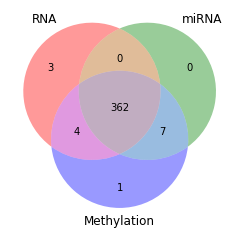

In [5]:
omics = load_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, cancer_type=CANCER_TYPE, norm=True)

In [6]:
X_train, X_test = train_test_split(omics, test_size = .2, random_state = 21, shuffle=True)

## **Best Auto-Encoder & K-Mean Clustering**

* **AE(vanilla, sparse, denoisy) - Model compile & Fit**

In [74]:
encoder_vanilla = run_ae(X_train=X_train, X_test=X_test)
encoder_sparse = run_ae_sparse(X_train=X_train, X_test=X_test)
encoder_denoisy = run_ae_denoisy(X_train=X_train, X_test=X_test)

best_ae_model(model_list=[encoder_vanilla, encoder_sparse, encoder_denoisy], o=omics,
              group_path=GROUP_PHTH, model_path=MODEL_PATH, cancer_type=CANCER_TYPE, file_name=FILE_NAME)

2022-01-20 15:35:08.780165: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/km/gitworking/Multi-omics-intergration/models/AE_encoder_denoisy_LIHC_20220120-150723/assets


INFO:tensorflow:Assets written to: /home/km/gitworking/Multi-omics-intergration/models/AE_encoder_denoisy_LIHC_20220120-150723/assets


Best AE : encoder_denoisy
Silhouette score : 0.1956


## **Select top N Feature**

* **Preprocessed Data Load**

In [81]:
data_type = ["rna", "mirna", "mt"]
feature_result = dict()

# load preprocess data
omics_preprocess = load_preprocess_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, 
                                     cancer_type=CANCER_TYPE, norm=True, 
                                     group_path=GROUP_PHTH + CANCER_TYPE + "_GROUP_" + FILE_NAME + ".txt")

* **Select N Feature**

In [ ]:
for d_type in data_type:
    print(d_type)
    
    tmp = list()
    df = omics_preprocess[d_type]
    y = df.pop('group')
    X = df
    
    # anova
    tmp.append(Feature_selection(y, X, "anova", univariate=True))
    
    # randomforest
    tmp.append(Feature_selection(y, X, "rf", univariate=False))
        
    feature_result[d_type] = tmp

* **Survival Analysis - logranktest**

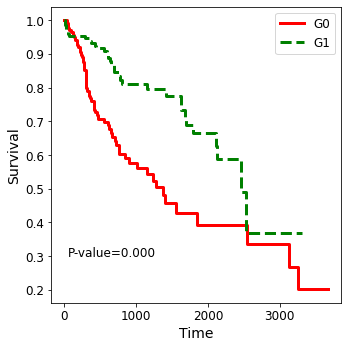

In [82]:
log_pvalue = log_rank_test(df=omics_preprocess["omics"], png_path=PNG_PATH, file_name=FILE_NAME)